In [1]:
import torch
import torch.nn as nn
import os

from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Set the seed for general torch operations
torch.manual_seed(42)
# Set the seed for CUDA torch operations (ones that happen on the GPU)
torch.cuda.manual_seed(42)

cuda


In [3]:
NUM_EPOCHS = 50
BATCH_SIZE = 128
NUM_WORKERS = 4
LEARNING_RATE = 0.002

In [4]:
train_dir = Path("./data/train/")
test_dir = Path("./data/test/")
class_names = os.listdir(test_dir)
print(class_names)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']


In [5]:
from torchvision.transforms import v2

train_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.RandomErasing(p=0.25),
        v2.RandAugment(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# cutmix = v2.CutMix(alpha=1.0, num_classes=len(class_names))
# mixup = v2.MixUp(alpha=0.8, num_classes=len(class_names))


# vig_augment = v2.RandomChoice([cutmix, mixup])

In [6]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(str(train_dir), transform=train_transforms)
test_dataset = datasets.ImageFolder(str(test_dir), transform=test_transforms)

train_dataset, test_dataset, class_names

(Dataset ImageFolder
     Number of datapoints: 1250
     Root location: data\train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=[0.0], inplace=False)
                  RandAugment(interpolation=InterpolationMode.NEAREST, num_ops=2, magnitude=9, num_magnitude_bins=31)
                  ToDtype(scale=True)
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 Dataset ImageFolder
     Number of datapoints: 500
     Root location: data\test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToDtype(scale=True)
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import default_collate


# def my_collate_fn(batch):
#     return vig_augment(*default_collate(batch))


train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    # collate_fn=my_collate_fn,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x210c7ccae90>,
 <torch.utils.data.dataloader.DataLoader at 0x210c7ccb4f0>)

In [8]:
from model_mobile_vig import mobilevig_ti
from model_vig import vig_ti_224_gelu
from torchinfo import summary

model = vig_ti_224_gelu(num_classes=len(class_names)).to(device)

# Print a summary using torchinfo (uncomment for actual output)
# summary(
#     model=model,
#     input_size=(
#         BATCH_SIZE,
#         3,
#         224,
#         224,
#     ),  # make sure this is "input_size", not "input_shape"
#     # col_names=["input_size"], # uncomment for smaller output
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"],
# )


dpr [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
num_knn [9, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18]


In [9]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=num_training_steps,
)

In [10]:
import torch.utils.data

from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    progress_bar: tqdm | None = None,
) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        lr_scheduler.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        if progress_bar:
            progress_bar.update(1)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [11]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
    progress_bar: tqdm | None = None,
) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            if progress_bar:
                progress_bar.update(1)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [12]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    use_progress_bar: bool = False,
) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    if use_progress_bar:
        progress_bar = tqdm(total=len(train_dataloader) + len(test_dataloader))

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            progress_bar=progress_bar if use_progress_bar else None,
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
            progress_bar=progress_bar if use_progress_bar else None,
        )

        print(
            f"LR: {lr_scheduler.get_last_lr()} | Epoch: {epoch+1} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {train_acc*100:.2f}% | Test acc: {test_acc*100:.2f}%"
        )
        progress_bar.reset()
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [13]:
import torch.nn as nn
from timeit import default_timer as timer

print(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Setup training and save the results
results = train(
    model=model.to(device),
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=torch.device(device),
    use_progress_bar=True,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

cuda


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

LR: [0.0019980267284282717] | Epoch: 1 | Train loss: 1.96291 | Test loss: 13.05020 | Train acc: 20.99% | Test acc: 24.47%
LR: [0.0019921147013144784] | Epoch: 2 | Train loss: 1.69435 | Test loss: 4.25922 | Train acc: 21.32% | Test acc: 19.38%
LR: [0.001982287250728689] | Epoch: 3 | Train loss: 1.66098 | Test loss: 1.69708 | Train acc: 20.79% | Test acc: 23.53%
LR: [0.0019685831611286303] | Epoch: 4 | Train loss: 1.62388 | Test loss: 1.60860 | Train acc: 22.09% | Test acc: 24.23%
LR: [0.0019510565162951525] | Epoch: 5 | Train loss: 1.64082 | Test loss: 1.57677 | Train acc: 23.89% | Test acc: 25.86%
LR: [0.0019297764858882498] | Epoch: 6 | Train loss: 1.62627 | Test loss: 1.67673 | Train acc: 25.93% | Test acc: 24.31%
LR: [0.0019048270524660179] | Epoch: 7 | Train loss: 1.60700 | Test loss: 1.56921 | Train acc: 24.93% | Test acc: 28.28%
LR: [0.0018763066800438618] | Epoch: 8 | Train loss: 1.59752 | Test loss: 1.56306 | Train acc: 24.97% | Test acc: 29.78%
LR: [0.0018443279255020131] | Ep

In [14]:
results["train_loss"][len(results)-1]

1.6238766312599182

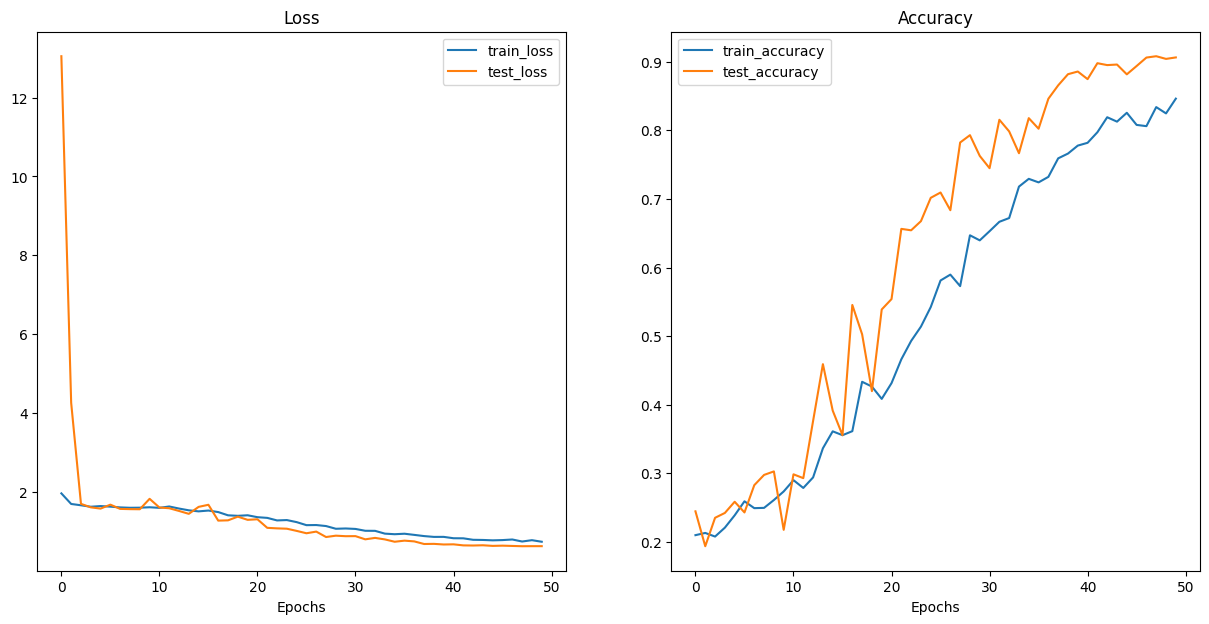

In [15]:
from helpers import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [16]:
save_dir = Path("./models/vig_isometric_50_epochs.pth")

torch.save(
    {
        "epoch": NUM_EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": results["train_loss"][len(results)-1],
    },
    save_dir,
)

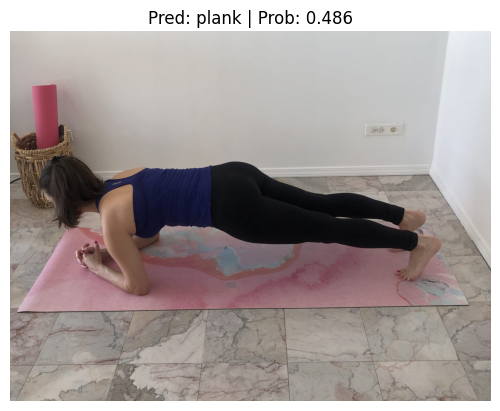

In [17]:
import helpers

# Setup path to data folder
custom_image_path = Path("./data/custom-data/elbowplank-911ae2.jpg")

# Predict on custom image
helpers.pred_and_plot_image(
    model=model, image_path=str(custom_image_path), class_names=class_names
)
